Epoch 1/25
247/247 [==============================] - 11s 32ms/step - loss: 0.0129 - val_loss: 0.0018 - lr: 0.0010
Epoch 2/25
247/247 [==============================] - 7s 27ms/step - loss: 0.0022 - val_loss: 8.6420e-04 - lr: 0.0010
Epoch 3/25
247/247 [==============================] - 7s 30ms/step - loss: 0.0016 - val_loss: 7.7501e-04 - lr: 0.0010
Epoch 4/25
247/247 [==============================] - 8s 31ms/step - loss: 0.0013 - val_loss: 7.3417e-04 - lr: 0.0010
Epoch 5/25
247/247 [==============================] - 7s 30ms/step - loss: 0.0011 - val_loss: 5.1592e-04 - lr: 0.0010
Epoch 6/25
247/247 [==============================] - 7s 30ms/step - loss: 9.9757e-04 - val_loss: 4.3268e-04 - lr: 0.0010
Epoch 7/25
247/247 [==============================] - 7s 29ms/step - loss: 9.2729e-04 - val_loss: 3.8169e-04 - lr: 0.0010
Epoch 8/25
247/247 [==============================] - 7s 30ms/step - loss: 8.5310e-04 - val_loss: 3.7386e-04 - lr: 0.0010
Epoch 9/25
247/247 [===========================

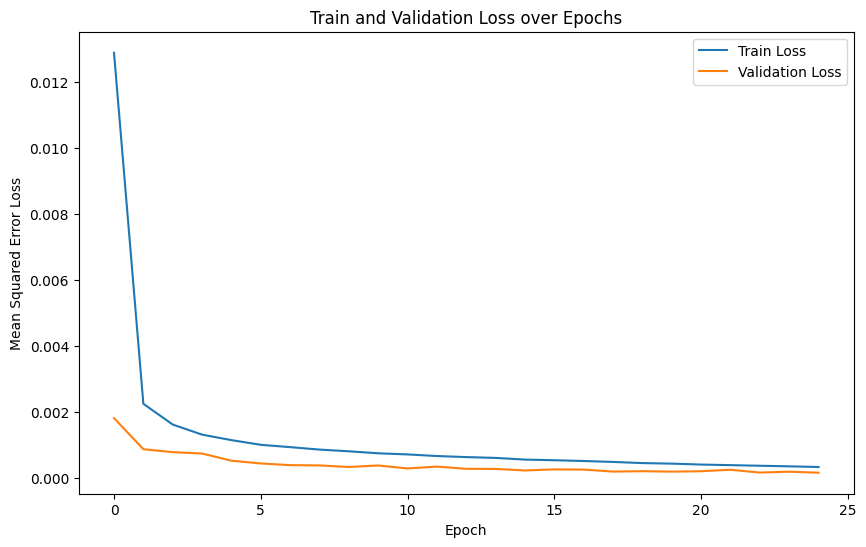

55/55 [==============================] - 1s 3ms/step
Test RMSE: 0.05
Test MAE: 0.04
Test R²: 1.00


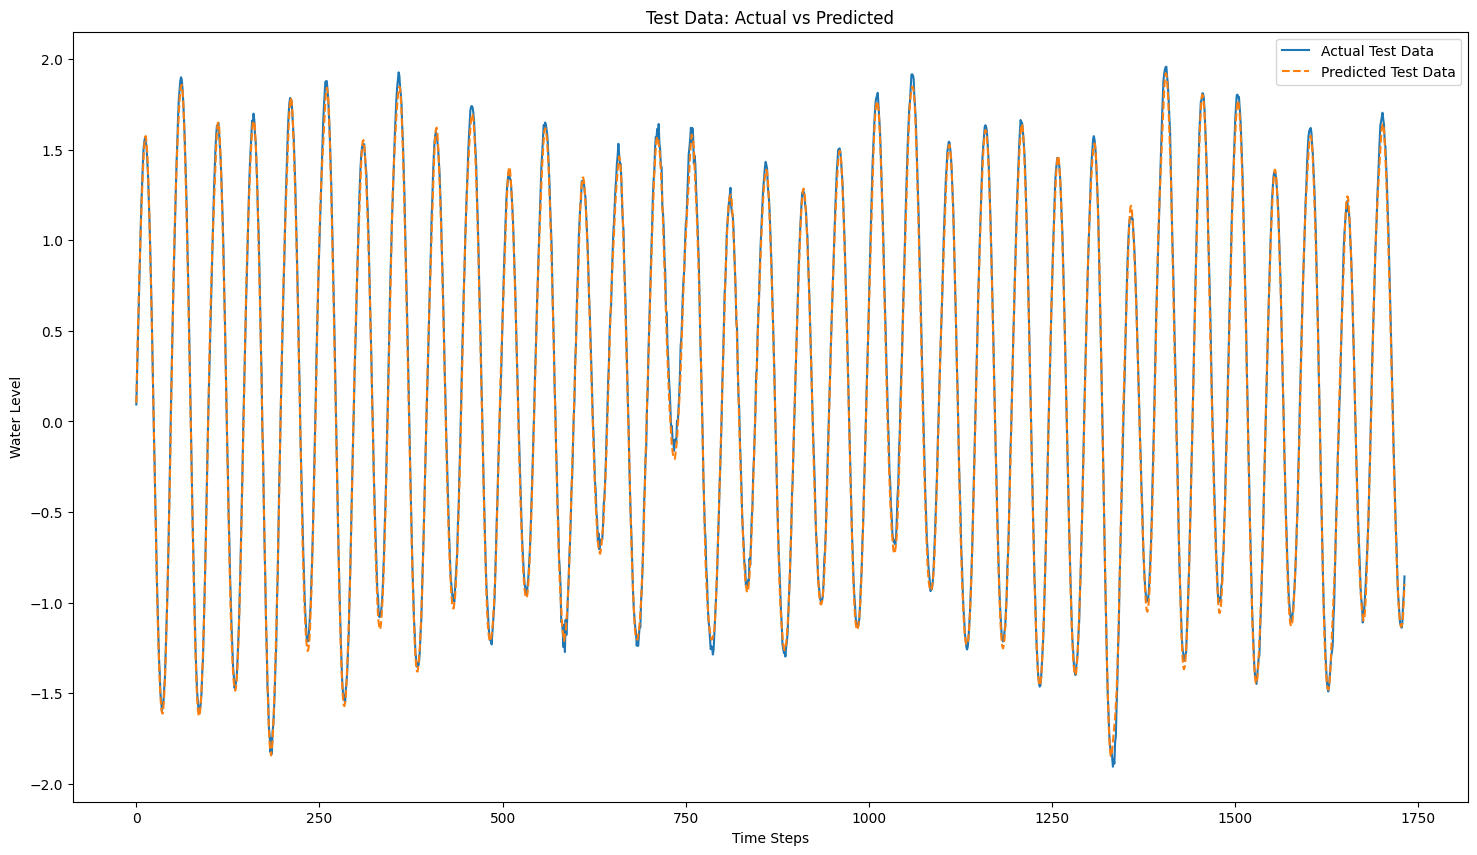

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义文件路径
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# 转换数据集函数，支持多输入特征
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        # 输入是过去 look_back 时间步的所有特征
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        # 输出是下一个时间步的目标变量（假设是第一个特征）
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 设置随机种子
np.random.seed(5)

# 加载数据集，假设有两列特征数据
df = read_csv(input_file, delimiter=',')
dataset = df[['anomaly', 'utide']].values  # 替换 'Another_Feature' 为你的第二列特征名

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

last = int(len(dataset) * 0.8)
dataset = dataset[last:, :]

# 分割数据集
train_size = int(len(dataset) * 0.9)  # 80% 用于训练
val_size = int(len(dataset) * 0.05)    # 10% 用于验证
test_size = len(dataset) - train_size - val_size  # 剩余 10% 用于测试
train, val, test = dataset[0:train_size, :], dataset[train_size:train_size + val_size, :], dataset[train_size + val_size:, :]

# 定义时间步长
look_back = 20
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

# 数据形状信息
num_features = trainX.shape[2]  # 输入特征数量

# 创建 BiLSTM 模型
learning_rate = 0.001  # 设置初始学习率
weight_decay = 0.0001  # 设置 L2 正则化系数

# 使用 Functional API 构建模型
input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(50, kernel_regularizer=l2(weight_decay)))(input_layer)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# 定义动态学习率回调
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# 使用验证集训练模型并记录损失
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=25, batch_size=128, verbose=1, callbacks=[reduce_lr])

# 绘制训练和验证损失
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# 测试集预测
predictions = model.predict(testX)

# 逆归一化预测值和实际值
predictions_full = np.zeros((len(predictions), num_features))
predictions_full[:, 0] = predictions.flatten()  # 填充预测目标
testY_full = np.zeros((len(testY), num_features))
testY_full[:, 0] = testY

# 逆归一化
predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
testY_inverse = scaler.inverse_transform(testY_full)[:, 0]

# 计算 R², RMSE 和 MAE
rmse = math.sqrt(mean_squared_error(testY_inverse, predictions_inverse))
mae = mean_absolute_error(testY_inverse, predictions_inverse)
r2 = r2_score(testY_inverse, predictions_inverse)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

# 绘制预测和实际值进行对比
plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="Actual Test Data")  # 测试集实际数据
plt.plot(predictions_inverse, label="Predicted Test Data", linestyle="--")  # 预测数据
plt.xlabel("Time Steps")
plt.ylabel("Water Level")
plt.title("Test Data: Actual vs Predicted")
plt.legend()
plt.show()


##一个输入变量

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义文件路径
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# 转换数据集函数，支持单输入维度
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        # 输入是过去 look_back 时间步的值
        a = dataset[i:(i + look_back), 0]  # 只选择第一个特征作为输入
        dataX.append(a)
        # 输出是下一个时间步的目标变量
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 设置随机种子
np.random.seed(5)

# 加载数据集，假设只有一个特征数据
df = read_csv(input_file, delimiter=',')
dataset = df[['anomaly']].values  # 只保留一个输入特征

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

last = int(len(dataset) * 0.8)
dataset = dataset[last:, :]

# 分割数据集
train_size = int(len(dataset) * 0.9)  # 80% 用于训练
val_size = int(len(dataset) * 0.05)    # 10% 用于验证
test_size = len(dataset) - train_size - val_size  # 剩余 10% 用于测试
train, val, test = dataset[0:train_size, :], dataset[train_size:train_size + val_size, :], dataset[train_size + val_size:, :]

# 定义时间步长
look_back = 1
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

# 重塑输入数据形状为 (样本数, 时间步, 特征数=1)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# 创建 BiLSTM 模型
learning_rate = 0.001  # 设置初始学习率
weight_decay = 0.0001  # 设置 L2 正则化系数

model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(look_back, 1), kernel_regularizer=l2(weight_decay))))
model.add(Dropout(0.1))
model.add(Dense(1))

# 编译模型
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# 定义动态学习率回调
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# 使用验证集训练模型并记录损失
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=25, batch_size=128, verbose=1, callbacks=[reduce_lr])

# 绘制训练和验证损失
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# 使用测试集直接预测
predictions = model.predict(testX)

# 逆归一化预测值和实际值
predictions = scaler.inverse_transform(predictions)  # 还原预测值
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))  # 还原实际值

# 计算 R², RMSE 和 MAE
rmse = math.sqrt(mean_squared_error(testY_inverse, predictions))
mae = mean_absolute_error(testY_inverse, predictions)
r2 = r2_score(testY_inverse, predictions)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

# 绘制预测和实际值进行对比
plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="Actual Test Data")  # 测试集实际数据
plt.plot(predictions, label="Predicted Test Data", linestyle="--")  # 预测数据
plt.xlabel("Time Steps")
plt.ylabel("Water Level")
plt.title("Test Data: Actual vs Predicted")
plt.legend()
plt.show()


Epoch 1/25


KeyboardInterrupt: 